
# Multi-Agent System for LeetCode Problem Solving

### Components:

1. **Parser** (with retry) - Fetches problem from LeetCode API
2. **Multi-Planner** (LLM) - Generates 2-3 different approaches
3. **Parallel Generators** (async LLM calls) - Generate solutions simultaneously
4. **Parallel Executors** (async) - Test all solutions in parallel
5. **Analyzer** (LLM) - Compares results and recommends best approach
6. **Finalizer** - Creates comprehensive report

### Key Features:

**ReAct Pattern**: LLM analyzes problem → chooses tools (approaches) → executes → reflects \
**Structured Output**: All responses use Pydantic models \
**Retry Logic**: Parser retries on failure (exponential backoff) \
**Parallelism**: `asyncio.gather()` for concurrent execution \
**Role Separation**: Separate LLM calls for planning, generation, analysis

### Tools:

- `leetcode_parser` - Parses problem description from LeetCode
- `code_executor` - Executes Python code with test cases

## Installation

```bash
pip install langchain langgraph langchain-openai pydantic requests beautifulsoup4 python-dotenv

Install dependencies:

pip install langchain langgraph langchain-openai pydantic requests beautifulsoup4 python-dotenv



In [138]:
import os
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()

# Verify required variables are set
required_vars = ['UNIVERSITY_API_BASE', 'UNIVERSITY_API_KEY']
missing_vars = [var for var in required_vars if not os.getenv(var)]

if missing_vars:
    raise ValueError(f"Missing environment variables: {', '.join(missing_vars)}")

print("Configuration loaded successfully")
print(f"API Base: {os.getenv('UNIVERSITY_API_BASE')}")
print(f"Model: {os.getenv('LLM_MODEL', 'qwen3-32b')}")

Configuration loaded successfully
API Base: http://a6k2.dgx:34000/v1
Model: qwen3-32b


1. Imports

In [139]:
from typing import Annotated, Optional, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
import requests
from bs4 import BeautifulSoup
import subprocess
import tempfile
import json
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

2. Pydantic Models for Structured Output

In [140]:
class LeetCodeTask(BaseModel):
    """Parsed task description from LeetCode"""
    problem_id: int = Field(description="Problem number")
    title: str = Field(description="Problem title")
    difficulty: str = Field(description="Difficulty: Easy/Medium/Hard")
    description: str = Field(description="Full problem description")
    examples: list[dict] = Field(description="Input/output examples")
    constraints: str = Field(description="Problem constraints")

class ApproachPlan(BaseModel):
    """Single approach plan for solving the problem"""
    name: str = Field(description="Approach name (hash_map, two_pointers, dp, etc.)")
    description: str = Field(description="Brief approach description")
    time_complexity: str = Field(description="Time complexity O(...)")
    space_complexity: str = Field(description="Space complexity O(...)")
    key_steps: list[str] = Field(description="Key algorithm steps")
    difficulty_estimate: str = Field(description="Implementation difficulty: easy/medium/hard")

class MultiApproachPlan(BaseModel):
    """Multiple approaches to solve the problem"""
    approaches: list[ApproachPlan] = Field(
        description="List of 2-3 different approaches",
        min_length=2,
        max_length=3
    )
    reasoning: str = Field(description="Why these approaches were chosen")

class ApproachSolution(BaseModel):
    """Solution for specific approach"""
    approach_name: str = Field(description="Name of the approach used")
    code: str = Field(description="Python code solution")
    explanation: str = Field(description="Solution explanation")
    function_name: str = Field(description="Function name to call")
    pros: list[str] = Field(description="Advantages of this approach")
    cons: list[str] = Field(description="Disadvantages of this approach")

class TestResult(BaseModel):
    """Result of a single test"""
    input_data: dict = Field(description="Input data")
    expected: str = Field(description="Expected result")
    actual: Optional[str] = Field(description="Actual result")
    passed: bool = Field(description="Test passed")
    error: Optional[str] = Field(description="Execution error if any")

class ExecutionResult(BaseModel):
    """Result of executing all tests"""
    success: bool = Field(description="All tests passed successfully")
    test_results: list[TestResult] = Field(description="Results of each test")
    total_tests: int = Field(description="Total number of tests")
    passed_tests: int = Field(description="Number of passed tests")

class ApproachResult(BaseModel):
    """Complete result of testing one approach"""
    approach_name: str = Field(description="Approach name")
    plan: ApproachPlan = Field(description="Original plan")
    solution: ApproachSolution = Field(description="Generated solution")
    execution: ExecutionResult = Field(description="Execution results")
    score: float = Field(description="Quality score (0-100)")

class ComparisonAnalysis(BaseModel):
    """Comparative analysis of all approaches"""
    recommended_approach: str = Field(description="Name of recommended approach")
    recommendation_reason: str = Field(description="Why this approach is recommended")
    comparison_table: str = Field(description="Markdown table comparing all approaches")
    detailed_analysis: str = Field(description="Detailed comparison with pros/cons")

class MultiSolutionReport(BaseModel):
    """Final report with ALL solutions"""
    success: bool = Field(description="At least one solution works")
    problem_title: str = Field(description="Problem title")
    problem_difficulty: str = Field(description="Problem difficulty")

    # All approaches results
    all_solutions: list[ApproachResult] = Field(description="All generated solutions")

    # Analysis and recommendation
    comparison: ComparisonAnalysis = Field(description="Comparative analysis")

    # Statistics
    total_approaches: int = Field(description="Total number of approaches tried")
    successful_approaches: int = Field(description="Number of working solutions")
    attempts: int = Field(description="Total generation attempts")

In [141]:
class ReactAction(BaseModel):
    """Действие ReAct-узла."""
    next_step: Literal["call_parser", "plan_approaches", "done"] = Field(
        description="Что делать на следующем шаге"
    )
    problem_id: Optional[int] = Field(
        default=None,
        description="Идентификатор задачи, если нужно вызвать парсер"
    )

3. Graph State

In [142]:
class GraphState(TypedDict):
    """Multi-agent system state"""
    problem_id: int
    language: str

    # Data from nodes
    task: Optional[LeetCodeTask]
    multi_plan: Optional[MultiApproachPlan]
    approach_results: list[ApproachResult]
    comparison: Optional[ComparisonAnalysis]
    final_report: Optional[MultiSolutionReport]

    # Control flow
    retry_count: int
    max_retries: int
    errors: Annotated[list[str], operator.add]

4. Tools

In [143]:
@tool
def leetcode_parser(problem_id: int) -> dict:
    """
    Parse problem description from LeetCode by problem number.

    Args:
        problem_id: Problem number on LeetCode

    Returns:
        dict with fields: title, difficulty, description, examples, constraints
    """
    try:
        # Use LeetCode GraphQL API (public)
        url = "https://leetcode.com/graphql"

        query = """
        query questionData($titleSlug: String!) {
            question(titleSlug: $titleSlug) {
                questionId
                title
                difficulty
                content
                exampleTestcases
            }
        }
        """

        # First, get titleSlug by problem number
        search_url = f"https://leetcode.com/api/problems/all/"
        response = requests.get(search_url, timeout=int(os.getenv('REQUEST_TIMEOUT', '10')))
        response.raise_for_status()

        problems = response.json()['stat_status_pairs']
        problem = next((p for p in problems if p['stat']['question_id'] == problem_id), None)

        if not problem:
            raise ValueError(f"Problem {problem_id} not found")

        title_slug = problem['stat']['question__title_slug']

        # Now get full problem description
        response = requests.post(
            url,
            json={'query': query, 'variables': {'titleSlug': title_slug}},
            timeout=int(os.getenv('REQUEST_TIMEOUT', '10'))
        )
        response.raise_for_status()

        data = response.json()['data']['question']

        # Parse HTML description
        soup = BeautifulSoup(data['content'], 'html.parser')

        # Extract examples
        examples = []
        for pre in soup.find_all('pre'):
            example_text = pre.get_text()
            if 'Input:' in example_text:
                examples.append({'text': example_text})

        return {
            'problem_id': problem_id,
            'title': data['title'],
            'difficulty': data['difficulty'],
            'description': soup.get_text(),
            'examples': examples[:3],  # Take first 3 examples
            'constraints': soup.get_text().split('Constraints:')[-1] if 'Constraints:' in soup.get_text() else ''
        }

    except Exception as e:
        raise Exception(f"Failed to parse LeetCode problem: {str(e)}")

@tool
def code_executor(code: str, function_name: str, test_cases: list[dict]) -> dict:
    """
    Execute Python code on test examples.

    Args:
        code: Python code to execute
        function_name: Function name to call
        test_cases: List of tests with input_data and expected fields

    Returns:
        dict with execution results
    """
    results = []

    for test in test_cases:
        try:
            # Create temporary file with code
            with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
                test_code = f"""
{code}

import json
test_input = {json.dumps(test['input_data'])}
result = {function_name}(**test_input)
print(json.dumps({{'result': str(result)}}))
"""
                f.write(test_code)
                temp_file = f.name

            # Execute code
            result = subprocess.run(
                ['python', temp_file],
                capture_output=True,
                text=True,
                timeout=int(os.getenv('CODE_EXECUTION_TIMEOUT', '5'))
            )

            if result.returncode == 0:
                output = json.loads(result.stdout.strip())
                actual = output['result']
                passed = actual == test['expected']

                results.append({
                    'input_data': test['input_data'],
                    'expected': test['expected'],
                    'actual': actual,
                    'passed': passed,
                    'error': None
                })
            else:
                results.append({
                    'input_data': test['input_data'],
                    'expected': test['expected'],
                    'actual': None,
                    'passed': False,
                    'error': result.stderr
                })

        except Exception as e:
            results.append({
                'input_data': test['input_data'],
                'expected': test['expected'],
                'actual': None,
                'passed': False,
                'error': str(e)
            })

    passed_count = sum(1 for r in results if r['passed'])

    return {
        'success': passed_count == len(results),
        'test_results': results,
        'total_tests': len(results),
        'passed_tests': passed_count
    }

In [144]:
import asyncio
from typing import Any, List
import re
import json
import time

async def safe_structured_call_async(
    llm: Any,
    schema: Any,
    messages: List[Any],
    retries: int = 3,
    backoff: float = 1.0,
):
    """Async версия structured-вызова LLM с парсингом JSON и retry."""
    def _fill_defaults(schema_cls: Any, payload: Any) -> Any:
        if not isinstance(payload, dict):
            return payload

        if hasattr(schema_cls, 'model_fields'):
            fields_info = schema_cls.model_fields
        elif hasattr(schema_cls, '__fields__'):
            fields_info = schema_cls.__fields__
        else:
            return payload

        for field_name, field_info in fields_info.items():
            if field_name not in payload:
                if hasattr(field_info, 'annotation'):
                    field_type = field_info.annotation
                elif hasattr(field_info, 'type_'):
                    field_type = field_info.type_
                else:
                    field_type = None

                origin = getattr(field_type, '__origin__', None)

                if origin is list:
                    payload[field_name] = []
                elif origin is dict:
                    payload[field_name] = {}
                elif field_type in (str, 'str'):
                    payload[field_name] = ""
                elif field_type in (int, 'int'):
                    payload[field_name] = 0
                elif field_type in (float, 'float'):
                    payload[field_name] = 0.0
                elif field_type in (bool, 'bool'):
                    payload[field_name] = False
                else:
                    payload[field_name] = None

            if field_name in payload and isinstance(payload[field_name], list):
                if hasattr(field_info, 'annotation'):
                    list_type = field_info.annotation
                    args = getattr(list_type, '__args__', ())
                    if args:
                        item_type = args[0]
                        if hasattr(item_type, 'model_fields') or hasattr(item_type, '__fields__'):
                            payload[field_name] = [
                                _fill_defaults(item_type, item) for item in payload[field_name]
                            ]

        return payload

    def _validate_model(schema_cls: Any, payload: Any):
        payload = _fill_defaults(schema_cls, payload)

        if hasattr(schema_cls, "model_validate"):
            return schema_cls.model_validate(payload)
        if hasattr(schema_cls, "parse_obj"):
            return schema_cls.parse_obj(payload)
        if isinstance(payload, dict):
            return schema_cls(**payload)
        return schema_cls(payload)

    last_exc = None
    for attempt in range(1, retries + 1):
        try:
            raw = await llm.ainvoke(messages)

            if isinstance(raw, str):
                text = raw
            else:
                if hasattr(raw, "content"):
                    text = raw.content
                elif isinstance(raw, (list, tuple)) and raw:
                    first = raw[0]
                    text = getattr(first, "content", str(first))
                else:
                    text = str(raw)

            text = (text or "").strip()
            if not text:
                raise ValueError("Empty LLM response")

            m = re.search(r'```(?:json)?\s*\n(.+?)```', text, flags=re.S)
            json_text = m.group(1).strip() if m else text

            try:
                parsed = json.loads(json_text)
            except Exception:
                start = json_text.find('{')
                end = json_text.rfind('}') + 1
                if start == -1 or end <= start:
                    raise ValueError("No JSON object found in response")
                parsed = json.loads(json_text[start:end])

            try:
                return _validate_model(schema, parsed)
            except Exception:
                if isinstance(parsed, dict) and ('parsed' in parsed or 'refusal' in parsed):
                    payload = parsed.get('parsed') or parsed.get('refusal')
                    return _validate_model(schema, payload)
                raise

        except Exception as e:
            last_exc = e
            if attempt == retries:
                raise
            wait = backoff * (2 ** (attempt - 1))
            await asyncio.sleep(wait)

    raise last_exc


def safe_structured_call(
    llm: Any,
    schema: Any,
    messages: List[Any],
    retries: int = 3,
    backoff: float = 1.0,
):
    """Синхронная обёртка над safe_structured_call_async для узлов LangGraph."""
    return asyncio.run(
        safe_structured_call_async(
            llm=llm,
            schema=schema,
            messages=messages,
            retries=retries,
            backoff=backoff,
        )
    )

In [145]:
async def generate_solution_async(task: LeetCodeTask, approach_plan: ApproachPlan, llm: Any) -> dict:
    """Generate solution for single approach asynchronously"""
    system_prompt = f"""You are an expert Python programmer specializing in algorithms.
Your task is to write clean, efficient code to solve a LeetCode problem.

Approach Plan:
- Approach: {approach_plan.name}
- Description: {approach_plan.description}
- Time complexity: {approach_plan.time_complexity}
- Space complexity: {approach_plan.space_complexity}

Strict requirements:
1. Code must be valid Python and fully self-contained (all imports inside `code` field).
2. Define exactly one public function with name `solution` and use this name in `function_name`.
3. The `code` field must contain the full code, not markdown and not comments only.
4. Add a clear docstring to `solution` explaining the algorithm.
5. Fill `pros` and `cons` as non-empty lists of short bullet points.
6. Do not include any markdown fences like ``` in the JSON.
7. Respond *strictly* in pure JSON matching the `ApproachSolution` schema. Do not wrap it in additional text."""

    user_prompt = f"""
Problem: {task.title}

Description:
{task.description}

Examples:
{json.dumps(task.examples, indent=2)}

Key steps for {approach_plan.name} approach:
{chr(10).join(f"{i+1}. {step}" for i, step in enumerate(approach_plan.key_steps))}

Generate solution using {approach_plan.name} approach.
"""

    solution = await safe_structured_call_async(llm, ApproachSolution, [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])

    # Simple validation to avoid completely empty solutions
    if not solution.code.strip():
        print(f"[warn] Empty code for approach `{approach_plan.name}`")
    if solution.function_name.strip() != "solution":
        print(f"[warn] Unexpected function_name `{solution.function_name}` for approach `{approach_plan.name}`")

    return {
        'approach_name': approach_plan.name,
        'plan': approach_plan,
        'solution': solution
    }


async def execute_tests_async(task: LeetCodeTask, solution_data: dict) -> dict:
    """Execute tests for single solution asynchronously."""
    solution = solution_data['solution']
    approach_name = solution_data['approach_name']

    test_cases = []
    for example in task.examples:
        example_text = example['text']
        if 'Input:' in example_text and 'Output:' in example_text:
            input_part = example_text.split('Input:')[1].split('Output:')[0].strip()
            output_part = example_text.split('Output:')[1].strip().split('\n')[0].strip()

            # Simple parsing for Two Sum style inputs:
            # "nums = [2,7,11,15], target = 9"
            nums_match = re.search(r'nums\s*=\s*(\[[^\]]*\])', input_part)
            target_match = re.search(r'target\s*=\s*([-\d]+)', input_part)

            if nums_match and target_match:
                try:
                    nums = json.loads(nums_match.group(1))
                    target = int(target_match.group(1))
                except Exception:
                    # Fallback: pass raw string if parsing fails
                    nums = input_part
                    target = None

                test_cases.append({
                    'input_data': {'nums': nums, 'target': target},
                    'expected': output_part,
                })

    try:
        loop = asyncio.get_event_loop()
        result = await loop.run_in_executor(
            None,
            code_executor.invoke,
            {
                'code': solution.code,
                'function_name': solution.function_name,
                'test_cases': test_cases,
            },
        )

        execution_result = ExecutionResult(**result)
        score = calculate_quality_score(execution_result, solution_data['plan'])

        return {
            'approach_name': approach_name,
            'plan': solution_data['plan'],
            'solution': solution,
            'execution': execution_result,
            'score': score,
        }

    except Exception as e:
        return {
            'approach_name': approach_name,
            'plan': solution_data['plan'],
            'solution': solution,
            'execution': ExecutionResult(
                success=False,
                test_results=[],
                total_tests=len(test_cases),
                passed_tests=0,
            ),
            'score': 0.0,
            'error': str(e),
        }

async def run_parallel_for_all_approaches(
    task: LeetCodeTask,
    multi_plan: MultiApproachPlan,
    llm: Any,
) -> list[ApproachResult]:
    """
    Run solution generation and test execution for all approaches in parallel.

    Steps:
    1. For each ApproachPlan, generate solution via LLM (in parallel).
    2. For each solution, execute tests (in parallel).
    3. Convert raw dicts to ApproachResult models.
    """
    # 1. Parallel solution generation
    gen_coros = [
        generate_solution_async(task=task, approach_plan=ap, llm=llm)
        for ap in multi_plan.approaches
    ]
    solutions_data = await asyncio.gather(*gen_coros)

    # 2. Parallel test execution
    exec_coros = [
        execute_tests_async(task=task, solution_data=sd)
        for sd in solutions_data
    ]
    exec_results = await asyncio.gather(*exec_coros)

    # 3. Normalize to list[ApproachResult]
    approach_results: list[ApproachResult] = []
    for res in exec_results:
        # If execute_tests_async returned error dict without proper execution,
        # we normalize fields safely.
        execution = res.get("execution")
        if isinstance(execution, dict):
            execution = ExecutionResult(**execution)

        plan = res.get("plan")
        if isinstance(plan, dict):
            plan = ApproachPlan(**plan)

        solution = res.get("solution")
        if isinstance(solution, dict):
            solution = ApproachSolution(**solution)

        score = float(res.get("score", 0.0))
        approach_results.append(
            ApproachResult(
                approach_name=res.get("approach_name", plan.name if plan else "unknown"),
                plan=plan,
                solution=solution,
                execution=execution,
                score=score,
            )
        )

    return approach_results


async def parallel_executor_node(state: GraphState) -> GraphState:
    """Async версия узла-исполнителя"""
    task = state["task"]
    multi_plan = state["multi_plan"]

    if task is None or multi_plan is None:
        raise ValueError("parallel_executor_node requires 'task' and 'multi_plan' in state")

    # Теперь просто await, без asyncio.run
    approach_results = await run_parallel_for_all_approaches(
        task=task,
        multi_plan=multi_plan,
        llm=llm,
    )

    state["approach_results"] = approach_results
    return state


def finalize_node(state: GraphState) -> GraphState:
    """Finalize Node: Create final report with all solutions and print them."""
    task = state['task']
    approach_results = state['approach_results']
    comparison = state['comparison']

    final_report = MultiSolutionReport(
        success=any(r.execution.success for r in approach_results),
        problem_title=task.title,
        problem_difficulty=task.difficulty,
        all_solutions=approach_results,
        comparison=comparison,
        total_approaches=len(approach_results),
        successful_approaches=sum(1 for r in approach_results if r.execution.success),
        attempts=state['retry_count'] + 1,
    )

    state['final_report'] = final_report

    print("==== Problem summary ====")
    print(f"Title: {final_report.problem_title}")
    print(f"Difficulty: {final_report.problem_difficulty}")
    print(f"Total approaches: {final_report.total_approaches}")
    print(f"Successful approaches: {final_report.successful_approaches}")
    print(f"Recommended approach: {final_report.comparison.recommended_approach}")
    print()

    print("==== Approaches detail ====")
    for idx, ar in enumerate(final_report.all_solutions, start=1):
        print(f"Approach {idx}: {ar.approach_name}")
        print(f"  Planned time complexity: {ar.plan.time_complexity}")
        print(f"  Planned space complexity: {ar.plan.space_complexity}")
        print(f"  Score: {ar.score:.2f}")
        print(f"  Tests passed: {ar.execution.passed_tests}/{ar.execution.total_tests}")
        if ar.execution.success:
            print("  Status: all tests passed")
        else:
            print("  Status: tests failed or not executed")

        print("  Pros:")
        for p in ar.solution.pros:
            print(f"    - {p}")
        print("  Cons:")
        for c in ar.solution.cons:
            print(f"    - {c}")

        print("  Code:")
        print("---------------- code start ----------------")
        print(ar.solution.code)
        print("----------------- code end -----------------")
        print()

        print("  Test details:")
        if not ar.execution.test_results:
            print("    No tests executed")
        else:
            for t_idx, tr in enumerate(ar.execution.test_results, start=1):
                print(f"    Test {t_idx}:")
                print(f"      Input: {tr.input_data}")
                print(f"      Expected: {tr.expected}")
                print(f"      Actual: {tr.actual}")
                print(f"      Passed: {tr.passed}")
                if tr.error:
                    print(f"      Error: {tr.error}")
        print()

    print("==== Comparison analysis ====")
    print(final_report.comparison.recommendation_reason)
    print()
    print("Comparison table (markdown):")
    print(final_report.comparison.comparison_table)

    return state

In [146]:
def react_node(state: GraphState) -> GraphState:
    """ReAct-узел: LLM решает, звать ли парсер или строить план."""
    system_prompt = (
        "Вы управляете процессом решения задачи LeetCode.\n"
        "У вас есть два инструмента:\n"
        "1. leetcode_parser(problem_id) — получить формулировку задачи.\n"
        "2. multi_planner — построить несколько подходов на основе уже распарсенной задачи.\n"
        "Состояние:\n"
        f"- task_present: {state.get('task') is not None}\n"
        "Верните решение в виде JSON по схеме ReactAction.\n"
        "Если задача ещё не распарсена, выберите call_parser.\n"
        "Если задача уже есть (task_present = true), выберите plan_approaches.\n"
        "Когда и парсинг, и план уже выполнены, можно вернуть done."
    )

    user_prompt = "Определите, какое действие нужно выполнить сейчас."

    action = safe_structured_call(
        llm,
        ReactAction,
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt),
        ],
    )

    if action.next_step == "call_parser":
        # Вызываем tool
        result = leetcode_parser.invoke({"problem_id": action.problem_id or state["problem_id"]})
        state["task"] = LeetCodeTask(**result)
    elif action.next_step == "plan_approaches":
        # Вызываем уже существующий планировщик как функцию
        state = multi_planner_node(state)
    elif action.next_step == "done":
        # Ничего не делаем, просто продолжаем по графу
        pass

    return state

5. Initialize LLM

In [147]:
llm = ChatOpenAI(
    base_url=os.getenv('UNIVERSITY_API_BASE'),
    api_key=os.getenv('UNIVERSITY_API_KEY'),
    model=os.getenv('LLM_MODEL', 'qwen3-32b'),
    #temperature=0
)

# Configuration from .env
MAX_RETRIES = int(os.getenv('MAX_RETRIES', '2'))

6. Graph Nodes

In [148]:
# %%
def parser_node(state: GraphState) -> GraphState:
    """
    Parser Node: Parse problem description from LeetCode (with retry logic)
    """
    problem_id = state['problem_id']

    try:
        # Call parsing tool
        result = leetcode_parser.invoke({'problem_id': problem_id})

        # Convert to Pydantic model
        task = LeetCodeTask(**result)
        state['task'] = task

    except Exception as e:
        error_msg = f"Parser error: {str(e)}"
        state['errors'].append(error_msg)

        # Retry logic is built into graph through conditional edges
        if state['retry_count'] < state['max_retries']:
            state['retry_count'] += 1
        else:
            raise Exception(f"Failed to parse after {state['max_retries']} attempts")

    return state

def multi_planner_node(state: GraphState) -> GraphState:
    """
    Multi-Planner Node: Analyze problem and create 2-3 different solution approaches
    """
    task = state['task']

    system_prompt = """You are an expert in algorithms and data structures.
Your task is to analyze a LeetCode problem and propose 2-3 DIFFERENT approaches to solve it.

Consider various strategies:
- Hash Map / Dictionary
- Two Pointers
- Sliding Window
- Dynamic Programming
- Divide and Conquer
- Greedy
- Binary Search
- BFS/DFS
- Backtracking

For EACH approach, provide:
1. Clear name (hash_map, two_pointers, etc.)
2. Brief description
3. Time and space complexity
4. Key algorithm steps
5. Implementation difficulty estimate

Choose approaches that represent different trade-offs (time vs space, simplicity vs optimization).

Respond strictly in JSON format according to MultiApproachPlan schema."""

    user_prompt = f"""
Problem: {task.title}
Difficulty: {task.difficulty}

Description:
{task.description}

Examples:
{json.dumps(task.examples, indent=2)}

Constraints:
{task.constraints}

Generate 2-3 different approaches to solve this problem.
"""

    response = safe_structured_call(llm, MultiApproachPlan, [
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])
    state['multi_plan'] = response
    return state

def create_solution_generator_node(approach_plan: ApproachPlan):
    """
    Factory function to create Solution Generator Node for specific approach.
    This allows parallel execution of different approaches.
    """
    def solution_generator_node(state: GraphState) -> dict:
        """
        Solution Generator Node: Generate code solution based on specific approach plan
        """
        task = state['task']

        system_prompt = f"""You are an expert Python programmer specializing in algorithms.
Your task is to write clean, efficient code to solve a LeetCode problem.

Approach Plan:
- Approach: {approach_plan.name}
- Description: {approach_plan.description}
- Time complexity: {approach_plan.time_complexity}
- Space complexity: {approach_plan.space_complexity}

Strict requirements:
1. Code must be valid Python and fully self-contained (all imports inside `code` field).
2. Define exactly one public function with name `solution` and use this name in `function_name`.
3. The `code` field must contain the full code, not markdown and not comments only.
4. Add a clear docstring to `solution` explaining the algorithm.
5. Fill `pros` and `cons` as non-empty lists of short bullet points.
6. Do not include any markdown fences like ``` in the JSON.
7. Respond strictly in JSON format according to `ApproachSolution` schema."""

        user_prompt = f"""
Problem: {task.title}

Description:
{task.description}

Examples:
{json.dumps(task.examples, indent=2)}

Key steps for {approach_plan.name} approach:
{chr(10).join(f"{i+1}. {step}" for i, step in enumerate(approach_plan.key_steps))}

Generate solution using {approach_plan.name} approach.
"""

        response = safe_structured_call(llm, ApproachSolution, [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ])

        if not response.code.strip():
            print(f"[warn] Empty code for approach `{approach_plan.name}`")
        if response.function_name.strip() != "solution":
            print(f"[warn] Unexpected function_name `{response.function_name}` for approach `{approach_plan.name}`")

        return {
            'approach_name': approach_plan.name,
            'plan': approach_plan,
            'solution': response
        }

    return solution_generator_node

def create_executor_node(approach_name: str):
    """
    Factory function to create Executor Node for specific approach.
    This allows parallel execution of tests for different solutions.
    """
    def executor_node(state: GraphState) -> dict:
        """
        Executor Node: Execute generated code on test examples
        """
        task = state['task']

        # Find solution for this approach from approach_results
        approach_data = next(
            (ar for ar in state['approach_results'] if ar.get('approach_name') == approach_name),
            None
        )

        if not approach_data:
            return {
                'approach_name': approach_name,
                'execution': ExecutionResult(
                    success=False,
                    test_results=[],
                    total_tests=0,
                    passed_tests=0
                ),
                'error': f"Solution for {approach_name} not found"
            }

        solution = approach_data['solution']

        # Prepare test cases from examples (как в execute_tests_async)
        test_cases = []
        for example in task.examples:
            example_text = example['text']
            if 'Input:' in example_text and 'Output:' in example_text:
                input_part = example_text.split('Input:')[1].split('Output:')[0].strip()
                output_part = example_text.split('Output:')[1].strip().split('\n')[0].strip()

                # Пример формата: "nums = [2,7,11,15], target = 9"
                nums_match = re.search(r'nums\s*=\s*(\[[^\]]*\])', input_part)
                target_match = re.search(r'target\s*=\s*([-\d]+)', input_part)

                if nums_match and target_match:
                    try:
                        nums = json.loads(nums_match.group(1))
                        target = int(target_match.group(1))
                    except Exception:
                        nums = input_part
                        target = None

                    test_cases.append({
                        'input_data': {'nums': nums, 'target': target},
                        'expected': output_part,
                    })

        try:
            # Call execution tool
            result = code_executor.invoke({
                'code': solution.code,
                'function_name': solution.function_name,
                'test_cases': test_cases
            })

            execution_result = ExecutionResult(**result)

            # Calculate quality score
            score = calculate_quality_score(
                execution_result,
                approach_data['plan']
            )

            return {
                'approach_name': approach_name,
                'execution': execution_result,
                'score': score
            }

        except Exception as e:
            error_msg = f"Execution error for {approach_name}: {str(e)}"
            state['errors'].append(error_msg)

            return {
                'approach_name': approach_name,
                'execution': ExecutionResult(
                    success=False,
                    test_results=[],
                    total_tests=len(test_cases),
                    passed_tests=0
                ),
                'score': 0.0,
                'error': error_msg
            }

    return executor_node

def calculate_quality_score(execution: ExecutionResult, plan: ApproachPlan) -> float:
    """
    Calculate quality score for a solution based on:
    - Test pass rate (50%)
    - Time complexity (25%)
    - Space complexity (15%)
    - Implementation difficulty (10%)
    """
    # Test pass rate score
    test_score = (execution.passed_tests / max(execution.total_tests, 1)) * 50

    # Time complexity score
    time_scores = {
        'O(1)': 25, 'O(log n)': 23, 'O(n)': 20,
        'O(n log n)': 15, 'O(n^2)': 10, 'O(2^n)': 5
    }
    time_score = next(
        (score for complexity, score in time_scores.items() if complexity in plan.time_complexity),
        10
    )

    # Space complexity score
    space_scores = {
        'O(1)': 15, 'O(log n)': 13, 'O(n)': 10, 'O(n^2)': 5
    }
    space_score = next(
        (score for complexity, score in space_scores.items() if complexity in plan.space_complexity),
        7
    )

    # Implementation difficulty score (inverse - easier is better)
    difficulty_scores = {'easy': 10, 'medium': 7, 'hard': 4}
    difficulty_score = difficulty_scores.get(plan.difficulty_estimate.lower(), 5)

    return test_score + time_score + space_score + difficulty_score

def analyzer_node(state: GraphState) -> GraphState:
    """Analyzer Node: compare all approaches and produce ComparisonAnalysis."""
    combined_results: list[ApproachResult] = state["approach_results"]
    task = state["task"]

    # Prepare summary for LLM
    results_summary = []
    for result in combined_results:
        results_summary.append({
            "approach": result.approach_name,
            "score": result.score,
            "tests_passed": f"{result.execution.passed_tests}/{result.execution.total_tests}",
            "time_complexity": result.plan.time_complexity,
            "space_complexity": result.plan.space_complexity,
            "pros": result.solution.pros,
            "cons": result.solution.cons,
            "explanation": result.solution.explanation,
        })

    system_prompt = (
        "You are an expert code reviewer and algorithm analyst.\n"
        "Your task is to compare multiple solutions to the same problem and provide:\n\n"
        "1. Recommendation: which approach is best overall and why\n"
        "2. Comparison table: a *markdown table as a single string*, comparing all approaches\n"
        "3. Detailed analysis: a *plain text string* with pros/cons of each approach\n\n"
        "The final JSON *must* follow this schema exactly:\n"
        "  - recommended_approach: string\n"
        "  - recommendation_reason: string\n"
        "  - comparison_table: string (markdown table only, not a list)\n"
        "  - detailed_analysis: string (plain text, not an object)\n"
    )

    user_prompt = (
        f"Problem: {task.title}\n"
        f"Difficulty: {task.difficulty}\n\n"
        f"All Solutions Results (JSON):\n{json.dumps(results_summary, indent=2)}\n\n"
        "Return a single JSON object. Do not wrap strings in additional JSON."
    )

    # 1. Получаем сырой dict из LLM
    raw = safe_structured_call(
        llm=llm,
        schema=dict,
        messages=[
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt),
        ],
    )

    # 2. Нормализуем типы под модель ComparisonAnalysis
    normalized: dict[str, Any] = dict(raw)

    # comparison_table должен быть строкой
    table = normalized.get("comparison_table")
    if not isinstance(table, str):
        # если пришёл список/словарь — сериализуем в markdown-подобный текст
        try:
            # Простая текстовая таблица из списка словарей
            if isinstance(table, list) and table:
                headers = sorted({k for row in table if isinstance(row, dict) for k in row.keys()})
                lines = []
                lines.append("| " + " | ".join(headers) + " |")
                lines.append("| " + " | ".join("---" for _ in headers) + " |")
                for row in table:
                    if not isinstance(row, dict):
                        continue
                    values = [str(row.get(h, "")) for h in headers]
                    lines.append("| " + " | ".join(values) + " |")
                normalized["comparison_table"] = "\n".join(lines)
            else:
                normalized["comparison_table"] = json.dumps(table, indent=2, ensure_ascii=False)
        except Exception:
            normalized["comparison_table"] = str(table)

    # detailed_analysis тоже должен быть строкой
    details = normalized.get("detailed_analysis")
    if not isinstance(details, str):
        try:
            normalized["detailed_analysis"] = json.dumps(
                details, indent=2, ensure_ascii=False
            )
        except Exception:
            normalized["detailed_analysis"] = str(details)

    # 3. Валидация через Pydantic-модель
    comparison = ComparisonAnalysis(**normalized)
    state["comparison"] = comparison
    return state

7. Build Graph with Parallel Execution

In [149]:
def should_retry_parser(state: GraphState) -> str:
    """Decide if parser needs retry"""
    if state.get('task') is not None:
        return "continue"
    elif state['retry_count'] < state['max_retries']:
        return "retry"
    else:
        return "fail"

# Create graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("parser", parser_node)
workflow.add_node("multi_planner", multi_planner_node)
workflow.add_node("parallel_executor", parallel_executor_node)
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("finalize", finalize_node)

# Set entry point
workflow.set_entry_point("parser")

# Parser with retry logic
workflow.add_conditional_edges(
    "parser",
    should_retry_parser,
    {
        "continue": "multi_planner",
        "retry": "parser",
        "fail": END
    }
)

# multi_planner -> parallel_executor -> analyzer
workflow.add_edge("multi_planner", "parallel_executor")
workflow.add_edge("parallel_executor", "analyzer")
workflow.add_edge("analyzer", "finalize")
workflow.add_edge("finalize", END)

workflow.add_edge("analyzer", "finalize")
workflow.add_edge("finalize", END)

# Compile graph
app = workflow.compile()

8. Graph Visualization

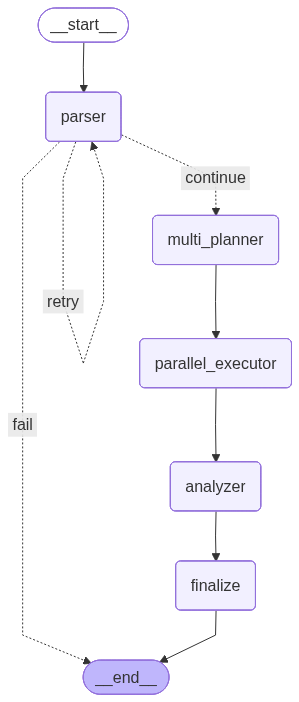

In [150]:
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization unavailable: {e}")
    print("\nText representation of graph:")
    print(app.get_graph().draw_ascii())

9. Main Execution Function

In [151]:
async def solve_leetcode_problem_parallel(
    problem_id: int,
    language: str = "python",
    max_retries: int = 2,
):
    """
    Run LangGraph workflow end-to-end for a single LeetCode problem (async).

    Args:
        problem_id: LeetCode problem number.
        language: Target programming language for solutions (currently used in prompts).
        max_retries: Maximum parser retries before failing.

    Returns:
        Final MultiSolutionReport object produced by the graph.
    """
    initial_state: GraphState = {
        "problem_id": problem_id,
        "language": language,
        "task": None,
        "multi_plan": None,
        "approach_results": [],
        "comparison": None,
        "final_report": None,
        "retry_count": 0,
        "max_retries": max_retries,
        "errors": [],
    }

    final_state = await app.ainvoke(initial_state)
    report = final_state.get("final_report")

    if report is None:
        raise RuntimeError("Graph finished without final_report in state")

    return report

10. Demo Execution

In [152]:
# Example: solve "Two Sum" problem (usually problem #1)
import nest_asyncio
nest_asyncio.apply()

report = await solve_leetcode_problem_parallel(
    problem_id=1,
    language="python",
    max_retries=2,
)

print("Title:", report.problem_title)
print("Difficulty:", report.problem_difficulty)
print("Total approaches:", report.total_approaches)
print("Successful approaches:", report.successful_approaches)
print("Recommended approach:", report.comparison.recommended_approach)

==== Problem summary ====
Title: Two Sum
Difficulty: Easy
Total approaches: 3
Successful approaches: 0
Recommended approach: hash_map

==== Approaches detail ====
Approach 1: hash_map
  Planned time complexity: O(n)
  Planned space complexity: O(n)
  Score: 35.00
  Tests passed: 0/3
  Status: tests failed or not executed
  Pros:
    - O(n) time complexity
    - Efficient for large input sizes up to 10^4 elements
  Cons:
    - Uses O(n) additional space for the hash map
    - Higher memory usage for very large input arrays
  Code:
---------------- code start ----------------
def solution(nums, target):
    """
    Solves the Two Sum problem using a hash map approach.

    Iterates through the list of numbers, maintaining a dictionary of previously seen
    numbers and their indices. For each number, checks if the complement (target - num)
    exists in the dictionary. If found, returns the indices of the complement and the
    current number. Otherwise, adds the current number to the di